# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#import some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import collections
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()
# show output in notebook
%matplotlib inline
# toggle automatic pdb
#%pdb

## Helper Functions

In [2]:
# Lane finder helper functions

def getImage(imageName):
    """Read image from file."""
    imageIn = mpimg.imread(imageName)

    #print out some stats
    print("'"+imageName+"'", 'is:', type(imageIn), 'with dimensions:', imageIn.shape)
    return imageIn

def saveImage(imageOut, fileName, cmapOut='gray'):
    """Write image to file."""
    mpimg.imsave(fileName, imageOut, cmap=cmapOut)
    absName = os.path.abspath('./'+fileName)
    print('Image saved as', absName)
    return absName

def showImage(imageIn):
    """Render image to screen."""
    plt.imshow(imageIn)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """

    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def clearHistoryCache():
    """Create and clear cache for inter-frame comparisons."""
    
    global slopeHistoryLeft
    global interceptHistoryLeft
    global slopeHistoryRight
    global interceptHistoryRight

    slopeHistoryLeft = collections.deque()
    interceptHistoryLeft = collections.deque()
    slopeHistoryRight = collections.deque()
    interceptHistoryRight = collections.deque()
    
    global mbLeftHist
    mbLeftHist = [collections.deque(), collections.deque()]
    global mbRightHist
    mbRightHist = [collections.deque(), collections.deque()]
    
def drawLanes(img, lines, color=[255, 0, 0], yTop=0, yBot=-1):
    """Draw interpolated lane lines onto blank image
    
    `img` should be edges
    `lines` should be output from `hough_lines`
    """
    
    if DEBUGGING:
        # overlay region-of-interest
        cv2.polylines(img, roi, isClosed=True, color=(0,255,0), thickness=1)
    ### DEBUGGING
    
    # make sure some hough lines were found
    if lines is None:
        return
    
    # default value
    if (yBot < 0):
        yBot = img.shape[0]


    # work in a right hand coordinate system where x' == image y and y' == image x
    yp1, xp1 = lines[...,0].astype(float, casting='same_kind'), lines[...,1].astype(float, casting='same_kind')
    yp2, xp2 = lines[...,2].astype(float, casting='same_kind'), lines[...,3].astype(float, casting='same_kind')
    
    # find slope and intercept for all line segments
    mp = (yp2-yp1)/(xp2-xp1)
    bp = yp1 - mp * xp1
    
    if DEBUGGING:
        drawRawLines(img, lines, [0, 255, 255])
    ### DEBUGGING

    # separate into left and right by slope, get rid of outliers, smooth between frames
    left = np.all([(mp < 0), (mp > -slopeThresh)], axis=0)
    if np.any(left):
        slopeHistoryLeft.append(np.mean(mp[left]))
        interceptHistoryLeft.append(np.mean(bp[left]))
        if len(slopeHistoryLeft) > maxHistory:
            slopeHistoryLeft.popleft
            interceptHistoryLeft.popleft
    else:
        if len(slopeHistoryLeft) == 0:
            return

    slopeLeft = np.mean(slopeHistoryLeft)
    interceptLeft = np.mean(interceptHistoryLeft)
    drawOneLine(img, slopeLeft, interceptLeft, yTop, yBot, color=leftLineColor)

    right = np.all([(mp > 0), (mp < slopeThresh)], axis=0)
    if np.any(right):
        slopeHistoryRight.append(np.mean(mp[right]))
        interceptHistoryRight.append(np.mean(bp[right]))
        if len(slopeHistoryRight) > maxHistory:
            slopeHistoryRight.popleft
            interceptHistoryRight.popleft
    else:
        if len(slopeHistoryRight) == 0:
            return
        
    slopeRight = np.mean(slopeHistoryRight)
    interceptRight = np.mean(interceptHistoryRight)
    drawOneLine(img, slopeRight, interceptRight, yTop, yBot, color=rightLineColor)
        
def drawOneLine(img, slope, intercept, yTop=0, yBot=-1, color=[255, 0, 0], thickness=4):
    """Extrapolate top to bottom of region of interest."""
    
    if (yBot < 0):
        yBot = img.shape[0]
    
    xBot = int(slope * yBot + intercept)
    xTop = int(slope * yTop + intercept)
    cv2.line(img, (xTop, yTop), (xBot, yBot), color, thickness)
    
def drawRawLines(img, lines, color=[255,0,0], thickness=2):
    """Output of `hough_lines`"""

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, yTop_, yBot_):
    """Returns an image with lane lines drawn from top to bottom.

    `img` should be the output of a Canny transform.
    """
  
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    drawLanes(line_img, lines, yTop=yTop_, yBot=yBot_)
    return line_img

# Python 3 has support for cool math symbols.

def addOverlay(overlay, initial_img):
    """Combine image with overlay
    
    `overlay` is the output of the hough_lines().
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the color image before any processing.
    
    NOTE: initial_img and overlay must be the same shape!
    """    
    # The result image is computed as follows:
    #initial_img * α + img * β + λ
    α, β, λ = 1.0, 0.8, 0.0
    return cv2.addWeighted(initial_img, α, overlay, β, λ)

def setSlopeThresh(minAngle_degrees=None):
    """Set slope threshold either with `minAngle or calculate from `roi`
    
    `minAngle_degrees` is absolute angle from horizontal 0 to 90
    `slopeThreshold` can be calculated from bottom-left corner of roi
    to a point at the top-center of roi (theoretical) horizon
    """
    
    global roi, slopeThresh
    if minAngle_degrees is None:
        yp1, xp1 = np.min(roi[...,0]), np.max(roi[...,1])
        yp2, xp2 = np.mean(roi[...,0]), np.min(roi[...,1])
        slopeThresh = math.fabs((yp2 - yp1) / (xp2 - xp1))
    else:
        slopeThresh = math.tan(math.radians(90 - minAngle_degrees))


## Set algorithm tuning parameters

In [3]:
# algorithm params for single image tests

# region of interest in sensor fov (area in front of car to look for lane lines)
roi = np.array([[[100,540],[430,360],[540,360],[920,540]]])

# top and botton image y coord for extrapolated lines
yTop, yBot = min(roi[0,:,1]), max(roi[0,:,1])

# lines marking left side of lane
leftLineColor = [0, 0, 255]

# lines marking right side of lane
rightLineColor = [255, 0, 0]

# Gaussian kernel size
smoothFactor = 7

# Canny edge parameters
lowThresh, highTresh = 100, 200

# hough rho bin size
rhoStep_pixels = 2

# hough theta bin size
thetaStep_degrees = np.pi/180

# bin count threshold
houghThresh = 30

# length between hough line end points for same line
minLineLength = 8

# gap between hough line end points to make separate lines
maxLineGap = 40

# minimum absolute angle of lane line from horizontal (0 to 90)
#setSlopeThresh(minAngle=30)
setSlopeThresh()

# number of frames to average
global maxHistory
maxHistory = 1



## Build a Lane Finding Pipeline



In [4]:
def findLane(colorImage):
    """Given a color image looking straigth forward,
    find and overlay the lane the car is currently in
    """
    
    edgeImage = canny(gaussian_blur(grayscale(colorImage), smoothFactor), lowThresh, highTresh)
    edgeCropped = region_of_interest(edgeImage, roi)
    linesImage= hough_lines(edgeCropped, rhoStep_pixels, thetaStep_degrees, houghThresh, minLineLength, maxLineGap, yTop, yBot)
    laneImage = addOverlay(linesImage, colorImage)
    return laneImage

'test_images/whiteCarLaneSwitch.jpg' is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
Image saved as /Users/ken/Dropbox/A_Udacity/CarND-LaneLines-P1/output_test_images/whiteCarLaneSwitchLane.png


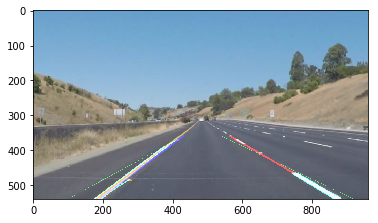

In [5]:
global DEBUGGING
DEBUGGING = True

def testSingleImage(inName):
    """Process single image"""

    clearHistoryCache()

    # read image, find lane, write to file.
    testImage = getImage(inName)
    testLane = findLane(testImage)
    showImage(testLane)
    outName, ext = os.path.splitext(os.path.basename(inName))
    outName = 'output_test_images/'+outName+'Lane.png'
    saveImage(testLane, outName)

testSingleImage('test_images/whiteCarLaneSwitch.jpg') 


In [ ]:
# process everything in test dir
global DEBUGGING
DEBUGGING = True
testDirName = 'test_images/'
for inName in os.listdir(testDirName):
    print('Processing...')
    inName = os.path.abspath(testDirName+inName)
    testSingleImage(inName)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

Let's try the one with the solid white lane on the right first ...

In [6]:
# algorithm params for solidWhiteRight.mp4

roi = np.array([[[100,530],[430,330],[540,330],[920,530]]])
yTop, yBot = min(roi[0,:,1]), max(roi[0,:,1])
leftLineColor = [255, 0, 0]
rightLineColor = [255, 0, 0]
smoothFactor = 7
lowThresh, highTresh = 100, 200
rhoStep_pixels = 2
thetaStep_degrees = np.pi/180
houghThresh = 30
minLineLength = 8
maxLineGap = 40
setSlopeThresh(minAngle_degrees=30)
global maxHistory
maxHistory = 15

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
global DEBUGGING
DEBUGGING = False
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line clip1 = ...
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
clearHistoryCache()
white_clip = clip1.fl_image(findLane) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 28.64it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.25 s, sys: 356 ms, total: 3.6 s
Wall time: 8.81 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
# algorithm params for solidYellowLeft.mp4

roi = np.array([[[100,530],[430,330],[540,330],[920,530]]])
yTop, yBot = min(roi[0,:,1]), max(roi[0,:,1])
leftLineColor = [255, 0, 0]
rightLineColor = [255, 0, 0]
smoothFactor = 7
lowThresh, highTresh = 100, 200
rhoStep_pixels = 2
thetaStep_degrees = np.pi/180
houghThresh = 30
minLineLength = 8
maxLineGap = 40
setSlopeThresh()
global maxHistory
maxHistory = 7

In [ ]:
global DEBUGGING
DEBUGGING = False
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
clearHistoryCache()
yellow_clip = clip2.fl_image(findLane)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

In [8]:
# algorithm params for challenge.mp4

#roi = np.array([[[220,690],[480,520],[860,520],[1150,690]]])
roi = np.array([[[100,700],[500,450],[800,450],[1200,700]]])
yTop, yBot = min(roi[0,:,1]), max(roi[0,:,1])
leftLineColor = [255, 0, 0]
rightLineColor = [255, 0, 0]
smoothFactor = 7
lowThresh, highTresh = 100, 200
rhoStep_pixels = 2
thetaStep_degrees = np.pi/180
houghThresh = 30
minLineLength = 8
maxLineGap = 40
setSlopeThresh()
global maxHistory
maxHistory = 15

global DEBUGGING
DEBUGGING = False

In [9]:
challenge_output = 'test_videos_output/challenge.mp4'
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
clearHistoryCache()
challenge_clip = clip3.fl_image(findLane)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:17<00:00, 13.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.31 s, sys: 1.55 s, total: 7.85 s
Wall time: 19.4 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))